In [58]:
# importazione delle librerie principali

import numpy as np #gestione di array e matrici
import pandas as pd #manipolazione dei dati
import matplotlib.pyplot as plt #creazioni di grafici
import seaborn as sns #creazioni di grafici più sofisticati

# lettura del database su vini bianchi
data=pd.read_csv("data/winequality-white.csv", sep=';')
#print(data.columns)
#data.head()

# definizione del target per classificazione (binaria)

data["target"] = (data["quality"] >= 6).astype(int)
print("Conteggio target (totale osservazioni):")
print(data [['target']].value_counts())

print("\nPercentuali:")
print((data["target"].value_counts(normalize=True) * 100).round(2))




Conteggio target (totale osservazioni):
target
1         3258
0         1640
Name: count, dtype: int64

Percentuali:
target
1    66.52
0    33.48
Name: proportion, dtype: float64


In [59]:
#il dataset è sbilanciato, utilizzo stratify per dividere i dati mantenendo le stesse percentuali delle classi per testarlo in modo equo

from sklearn.model_selection import train_test_split

# Variabili
X = data.drop(columns=["quality", "target"])
y = data["target"]

# Split stratificato (prima 70/30 per isolare il training, poi 20/10 per validation e test)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.30,    # 30% va in temp
    stratify=y,
    random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=1/3,   # cioè 10% del totale
    stratify=y_temp,
    random_state=42
)

# Verifica proporzioni
print("Proporzioni originali:")
print(data["target"].value_counts(normalize=True).round(3))

print("\nProporzioni training set:")
print(y_train.value_counts(normalize=True).round(3))

print("\nProporzioni validation set:")
print(y_val.value_counts(normalize=True).round(3))

print("\nProporzioni test set:")
print(y_test.value_counts(normalize=True).round(3))


# Controllo delle dimensioni
print("Training set:", X_train.shape)
print("Validation set:", X_val.shape)
print("Test set:", X_test.shape)

Proporzioni originali:
target
1    0.665
0    0.335
Name: proportion, dtype: float64

Proporzioni training set:
target
1    0.665
0    0.335
Name: proportion, dtype: float64

Proporzioni validation set:
target
1    0.665
0    0.335
Name: proportion, dtype: float64

Proporzioni test set:
target
1    0.665
0    0.335
Name: proportion, dtype: float64
Training set: (3428, 11)
Validation set: (980, 11)
Test set: (490, 11)


In [61]:
# adesso standardizziamo le feature con la funzione standarscaler

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)   # fit + transform SOLO sul training per evitare che il modello apprenda informazioni future. Fit salva dentro scaler le medie e deviazioni. Transform le riutilizza per standardizzare val e test
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)
# controllo
print("Train scalato:", X_train_s.shape)
print("Val scalato:", X_val_s.shape)
print("Test scalato:", X_test_s.shape)

#adesso abbiamo due tre nuove matrici standardizzate che lasciano invariato il database di partenza. le medie  sono tendenti a 0 mentre la deviazione standard a 1

scaled_df = pd.DataFrame(X_train_s, columns=X.columns)
print(scaled_df.mean())
print(scaled_df.std())


Train scalato: (3428, 11)
Val scalato: (980, 11)
Test scalato: (490, 11)
fixed acidity           9.918165e-16
volatile acidity        0.000000e+00
citric acid            -4.497893e-16
residual sugar         -9.120152e-17
chlorides              -5.845188e-16
free sulfur dioxide     1.409478e-16
total sulfur dioxide   -2.134945e-16
density                -1.063430e-14
pH                     -1.363877e-15
sulphates               4.456438e-16
alcohol                -8.456868e-16
dtype: float64
fixed acidity           1.000146
volatile acidity        1.000146
citric acid             1.000146
residual sugar          1.000146
chlorides               1.000146
free sulfur dioxide     1.000146
total sulfur dioxide    1.000146
density                 1.000146
pH                      1.000146
sulphates               1.000146
alcohol                 1.000146
dtype: float64
fixed acidity          -0.004857
volatile acidity        0.022908
citric acid             0.057131
residual sugar          0.00

Varianza spiegata da PC1 e PC2:
[0.2923 0.1449]


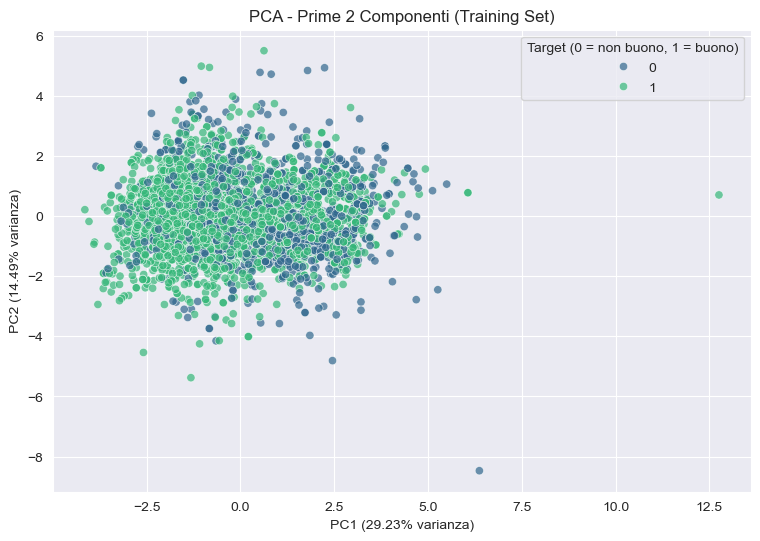

In [57]:
#adesso applichiamo la PCA: prendiamo le 11 feature del vino e le combiniamo in due nuove variabili pc1 e pc2 che catturano la massima varianza possibile e sono tra loro indipendenti.

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_s)   # fit + transform SOLO su train come sopra
X_val_pca = pca.transform(X_val_s)
X_test_pca = pca.transform(X_test_s)

print("Varianza spiegata da PC1 e PC2:")
print(pca.explained_variance_ratio_.round(4))

# DataFrame PCA per grafico
pca_df = pd.DataFrame({
    "PC1": X_train_pca[:, 0],
    "PC2": X_train_pca[:, 1],
    "target": y_train.values
})

# Grafico PCA 2D
plt.figure(figsize=(9,6))
sns.scatterplot(
    data=pca_df,
    x="PC1", y="PC2",
    hue="target",
    palette="viridis",
    alpha=0.7
)
plt.title("PCA - Prime 2 Componenti (Training Set)")
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% varianza)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% varianza)")
plt.legend(title="Target (0 = non buono, 1 = buono)")
plt.show()


Accuracy: 0.7785714285714286
Precision: 0.8138528138528138
Recall: 0.8650306748466258
F1-score: 0.8386617100371747
ROC-AUC: 0.8306290213975759


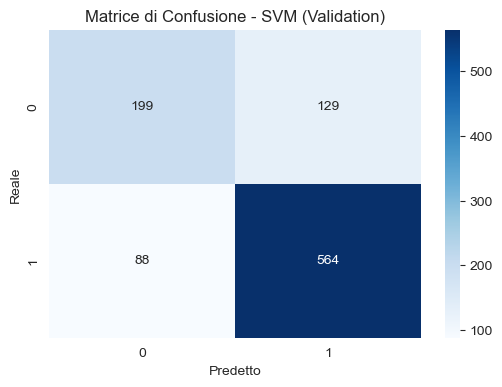

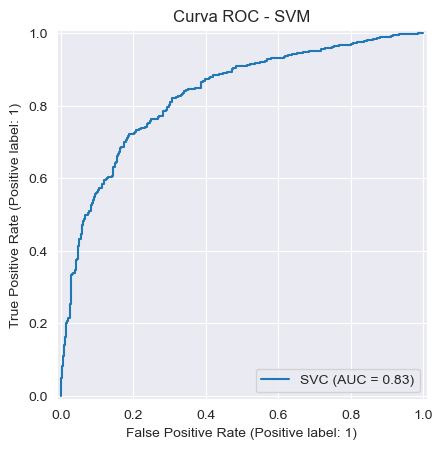

In [66]:
# partiamo con algoritmo SVC
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay

svm = SVC(
    C=1,                # penalità standard
    kernel='rbf',       # kernel gaussiano
    gamma='scale',      # impostazione moderna e stabile
    probability=True    # necessario per ROC curve
)

# Addestramento sul training set
svm.fit(X_train_s, y_train)

# Predizione sul validation set
y_val_pred = svm.predict(X_val_s)
y_val_proba = svm.predict_proba(X_val_s)[:,1]

# Metriche di valutazione
print("Accuracy:",  accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:",    recall_score(y_val, y_val_pred))
print("F1-score:",  f1_score(y_val, y_val_pred))
print("ROC-AUC:",   roc_auc_score(y_val, y_val_proba))

# Matrice di confusione
cm = confusion_matrix(y_val, y_val_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice di Confusione - SVM (Validation)")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(svm, X_val_s, y_val)
plt.title("Curva ROC - SVM")
plt.show()



Accuracy: 0.8316326530612245
Precision: 0.8565153733528551
Recall: 0.897239263803681
F1-score: 0.8764044943820225
ROC-AUC: 0.9007720148137064


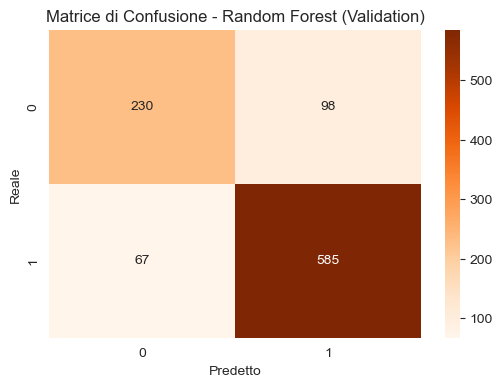

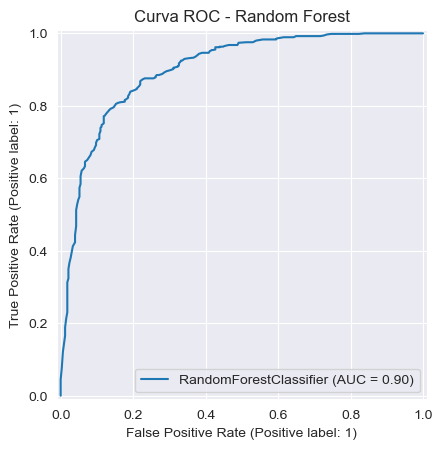


Importanza delle feature:
alcohol                 0.150258
volatile acidity        0.122522
density                 0.107790
free sulfur dioxide     0.096839
citric acid             0.082173
total sulfur dioxide    0.080513
chlorides               0.079284
residual sugar          0.079095
pH                      0.071508
fixed acidity           0.065804
sulphates               0.064214
dtype: float64


In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay

# Modello Random Forest base
rf = RandomForestClassifier(
    n_estimators=200,     # numero alberi
    max_depth=None,       # profondità libera
    random_state=42
)

# Addestramento sul training
rf.fit(X_train_s, y_train)

# Predizione sulla validation
y_val_pred_rf = rf.predict(X_val_s)
y_val_proba_rf = rf.predict_proba(X_val_s)[:, 1]

# Metriche di valutazione
print("Accuracy:",  accuracy_score(y_val, y_val_pred_rf))
print("Precision:", precision_score(y_val, y_val_pred_rf))
print("Recall:",    recall_score(y_val, y_val_pred_rf))
print("F1-score:",  f1_score(y_val, y_val_pred_rf))
print("ROC-AUC:",   roc_auc_score(y_val, y_val_proba_rf))

# Matrice di confusione
cm_rf = confusion_matrix(y_val, y_val_pred_rf)

plt.figure(figsize=(6,4))
sns.heatmap(cm_rf, annot=True, fmt="d", cmap="Oranges")
plt.title("Matrice di Confusione - Random Forest (Validation)")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(rf, X_val_s, y_val)
plt.title("Curva ROC - Random Forest")
plt.show()

# Importanza delle feature Random Forest
feature_imp = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

print("\nImportanza delle feature:")
print(feature_imp)


Accuracy: 0.7173469387755103
Precision: 0.783661119515885
Recall: 0.7944785276073619
F1-score: 0.789032749428789
ROC-AUC: 0.7678484587759988


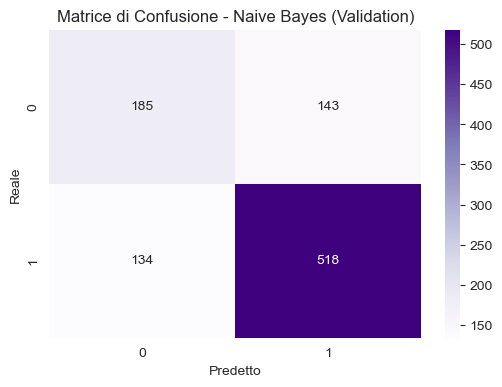

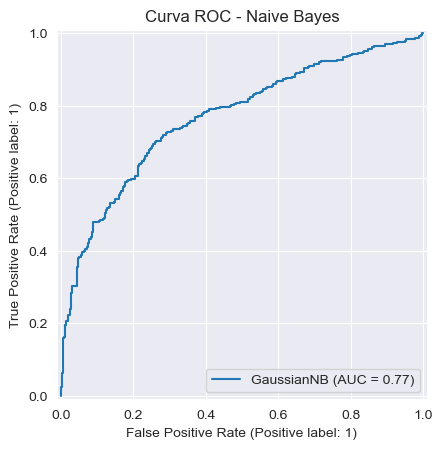

In [54]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, RocCurveDisplay

# Modello Naive Bayes utilizzando Gaussian perchè abbiamo feature continue
nb = GaussianNB()

# Addestramento sul training set
nb.fit(X_train_s, y_train)

# Predizione sulla validation
y_val_pred_nb = nb.predict(X_val_s)
y_val_proba_nb = nb.predict_proba(X_val_s)[:,1]

# Metriche di valutazione
print("Accuracy:",  accuracy_score(y_val, y_val_pred_nb))
print("Precision:", precision_score(y_val, y_val_pred_nb))
print("Recall:",    recall_score(y_val, y_val_pred_nb))
print("F1-score:",  f1_score(y_val, y_val_pred_nb))
print("ROC-AUC:",   roc_auc_score(y_val, y_val_proba_nb))

# Matrice di confusione
cm_nb = confusion_matrix(y_val, y_val_pred_nb)

plt.figure(figsize=(6,4))
sns.heatmap(cm_nb, annot=True, fmt="d", cmap="Purples")
plt.title("Matrice di Confusione - Naive Bayes (Validation)")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()

# ROC Curve
RocCurveDisplay.from_estimator(nb, X_val_s, y_val)
plt.title("Curva ROC - Naive Bayes")
plt.show()

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step
Accuracy: 0.7806122448979592
Precision: 0.8152958152958153
Recall: 0.8665644171779141
F1-score: 0.8401486988847584
ROC-AUC: 0.8431047059703727


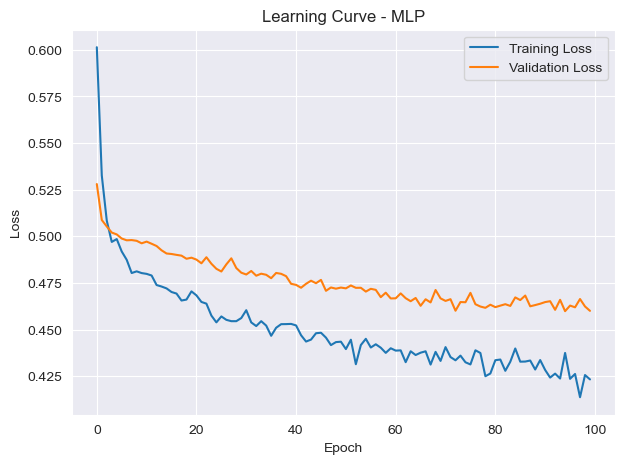

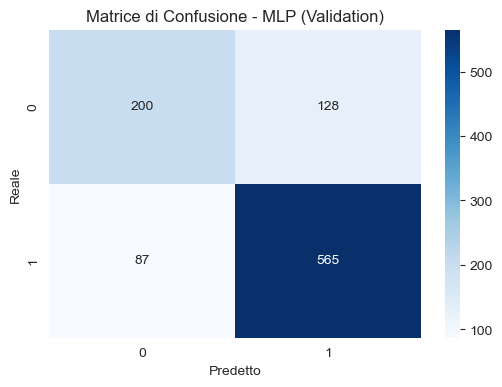

<Figure size 700x500 with 0 Axes>

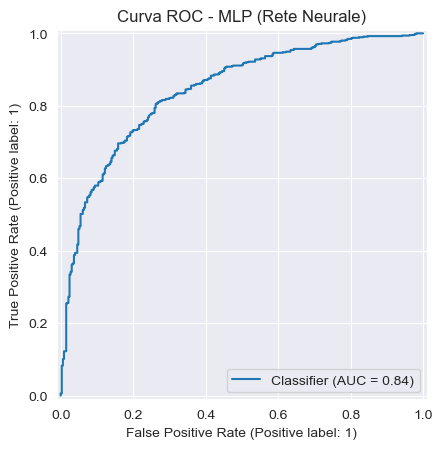

In [80]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential #costrusce la rete strato dopo strato
from tensorflow.keras.layers import Dense, Dropout #definisce i neuroni e una tecnica che li spegne a caso per ridurre overfitting
from tensorflow.keras.optimizers import Adam #ottimizzatore dei pesi durante l'addestramento

model = Sequential([
    Input(shape=(X_train_s.shape[1],)),  #strato che riceve i dati chimici del vino
    Dense(32, activation='relu'), #primo strato nascosto con 32 neuroni che ignora i valori negativi
    Dropout(0.2), #spegne il 20% dei neuroni attivi per evitare overfitting
    Dense(16, activation='relu'), #secondo strato nascosto con 16 neuroni che migliorano il ragionamento
    Dropout(0.2),
    Dense(1, activation='sigmoid') #strato di uscita con 1 neurone che indica 0 o 1 in caso di vino cattivo o buono
])

model.compile(
    optimizer=Adam(learning_rate=0.001), # definizione di quanto velocemente impara la rete
    loss='binary_crossentropy', #funzione che indica quanto la rete sbaglia ad ogni previsione
    metrics=['accuracy'] #misura quante volte indovina sulle classi finali
)

# Addestramento
history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=100, #ripetizione dell'addestramento
    batch_size=16, #ogni quanti esempi aggiorna i pesi
    verbose=0
)

# Predizioni
y_val_proba = model.predict(X_val_s).ravel()  # probabilità classe 1 = vino buono
y_val_pred = (y_val_proba >= 0.5).astype(int) #applichiamo una soglia >=0,5 - vino buono

# Metriche
print("Accuracy:",  accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:",    recall_score(y_val, y_val_pred))
print("F1-score:",  f1_score(y_val, y_val_pred))
print("ROC-AUC:",   roc_auc_score(y_val, y_val_proba))

# Learning curves
plt.figure(figsize=(7,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Learning Curve - MLP")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

cm = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Matrice di Confusione - MLP (Validation)")
plt.xlabel("Predetto")
plt.ylabel("Reale")
plt.show()

plt.figure(figsize=(7,5))
RocCurveDisplay.from_predictions(y_val, y_val_proba)
plt.title("Curva ROC - MLP (Rete Neurale)")
plt.grid(True)
plt.show()

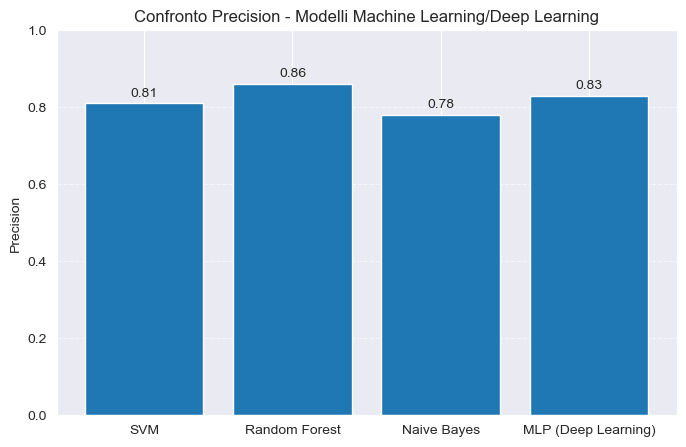

In [78]:
# Precision ottenute dai tuoi modelli
precision_svm = 0.81
precision_rf  = 0.86
precision_dt  = 0.78
precision_mlp = 0.83

model_names = ["SVM", "Random Forest", "Naive Bayes", "MLP (Deep Learning)"]
precision_scores = [precision_svm, precision_rf, precision_dt, precision_mlp]

# Grafico a colonne
plt.figure(figsize=(8,5))
bars = plt.bar(model_names, precision_scores)

# Etichette sopra le barre
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}",
             ha='center', va='bottom')

plt.title("Confronto Precision - Modelli Machine Learning/Deep Learning")
plt.ylabel("Precision")
plt.ylim(0,1) # scala da 0 a 1
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()